# Sequence Prediction with (Bi-)LSTMs

## Data

We need to get some data. We use the same CoNLL reader function as we had for the Structured Perceptron.

In [ ]:
def read_conll_file(file_name):
    """
    read in a file with CoNLL format:
    word1    tag1
    word2    tag2
    ...      ...
    wordN    tagN

    Sentences MUST be separated by newlines!
    """
    current_words = []
    current_tags = []

    with open(file_name, encoding='utf-8') as conll:
        for line in conll:
            line = line.strip()

            if line:
                word, tag = line.split('\t')
                current_words.append(word)
                current_tags.append(tag)

            else:
                yield (current_words, current_tags)
                current_words = []
                current_tags = []

    # if file does not end in newline (it should...), check whether there is an instance in the buffer
    if current_tags != []:
        yield (current_words, current_tags)

Now we need to do some bookkeeping: collect the set of known words and tags, map both words and tags into integer indices, and keep track of the mapping. We also need two special tokens: one for unknown words, the other one for padding.

In [ ]:
# collect known word tokens and tags
wordset, tagset = set(), set()
train_instances = [(words, tags) for (words, tags) in read_conll_file('tiny_POS_train.data')]
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

In [ ]:
# get some test data
test_instances = [(words, tags) for (words, tags) in read_conll_file('tiny_POS_test.data')]

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

['Showtime', 'is', 'a', 'distant', 'No.', '0', 'to', 'Home', 'Box', 'Office', ',', 'and', 'in', 'May', 'filed', 'a', '$', '0.0', 'billion', 'antitrust', 'suit', 'against', 'Time', 'Warner', ',', 'charging', 'the', 'company', 'and', 'its', 'HBO', 'and', 'American', 'Television', 'cable', 'units', 'with', 'conspiring', 'to', 'monopolize', 'the', 'pay', 'TV', 'business', '.']
[1789, 4586, 2131, 3496, 1433, 25, 6898, 929, 331, 1472, 20, 2336, 4422, 1282, 3917, 2131, 3, 31, 2627, 2357, 6697, 2255, 1949, 2054, 20, 2878, 6829, 3000, 2336, 4594, 875, 2336, 175, 1917, 2780, 7069, 7309, 3104, 6898, 5051, 6829, 5413, 1899, 2755, 23]
['NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'NUM', 'ADP', 'NOUN', 'NOUN', 'NOUN', '.', 'CONJ', 'ADP', 'NOUN', 'VERB', 'DET', '.', 'NUM', 'NUM', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.', 'VERB', 'DET', 'NOUN', 'CONJ', 'PRON', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'NOUN', 'NOUN', '.']
[7, 11, 6, 2, 7, 8, 3, 7, 7, 7, 1, 

In [ ]:
test_instances_int[0]

[2,
 7,
 3,
 6,
 7,
 7,
 5,
 7,
 7,
 11,
 7,
 6,
 11,
 11,
 4,
 6,
 2,
 7,
 7,
 7,
 11,
 11,
 7,
 1,
 11,
 6,
 2,
 7,
 3,
 6,
 7,
 10,
 7,
 3,
 2,
 7,
 1]

Even though RNNs theoretically work for any length input, in practice, we need to make every sentence the same length. We choose the longest training sentence, add some extra, and then pad everything up to that length.

In [ ]:
# get longest training sentence and add 5
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)


87


## Exercise

Instead of the longest sentence, find the 90th percentile of all training sentence length.

In [ ]:
# Your code here


## Padding

`Keras` provides a function to do the padding for us:

In [ ]:
from keras.preprocessing.sequence import pad_sequences
 
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences[0])
print(train_tags[0])

[1789 4586 2131 3496 1433   25 6898  929  331 1472   20 2336 4422 1282
 3917 2131    3   31 2627 2357 6697 2255 1949 2054   20 2878 6829 3000
 2336 4594  875 2336  175 1917 2780 7069 7309 3104 6898 5051 6829 5413
 1899 2755   23    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[ 7 11  6  2  7  8  3  7  7  7  1  5  3  7 11  6  1  8  8  2  7  3  7  7
  1 11  6  7  5  9  7  5  7  7  7  7  3 11 10 11  6  7  7  7  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Model

We use the [functional API](https://keras.io/getting-started/functional-api-guide/) in `keras`. Each layer is a function, which takes as input the previous layer.

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 87)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 87, 128)           945408    
_________________________________________________________________
LSTM (LSTM)                  (None, 87, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 87, 256)           0         
_________________________________________________________________
output (Dense)               (None, 87, 13)            3341      
_________________________________________________________________
softmax (Activation)         (None, 87, 13)            0         
Total params: 1,342,989
Trainable params: 1,342,989
Non-trainable params: 0
_________________________________________________

In order to read the tags, the model needs 1-hot encoding, i.e., a vector with one dimension for each tag, all of them 0, except the one dimension corresponding to the tag we have. Lucikly, there exists a utility function for it.

In [ ]:
from keras.utils import to_categorical

train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# originally 50 tag IDs
print(train_tags[0])
# now 50 rows with 13 columns
print(train_tags_1hot[0].shape)
# the 1-hot encoding of tag ID 7
print(train_tags_1hot[0])

[ 7 11  6  2  7  8  3  7  7  7  1  5  3  7 11  6  1  8  8  2  7  3  7  7
  1 11  6  7  5  9  7  5  7  7  7  7  3 11 10 11  6  7  7  7  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(87, 13)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Now we can train the model

In [ ]:
batch_size = 16
epochs = 5

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/5
101/101 [==============================] - 46s 408ms/step - loss: 0.5927 - accuracy: 0.3354 - val_loss: 0.2656 - val_accuracy: 0.7302
Epoch 2/5
101/101 [==============================] - 40s 399ms/step - loss: 0.1772 - accuracy: 0.7995 - val_loss: 0.0976 - val_accuracy: 0.9027
Epoch 3/5
101/101 [==============================] - 38s 381ms/step - loss: 0.0522 - accuracy: 0.9495 - val_loss: 0.0789 - val_accuracy: 0.9198
Epoch 4/5
101/101 [==============================] - 39s 383ms/step - loss: 0.0295 - accuracy: 0.9699 - val_loss: 0.0726 - val_accuracy: 0.9240
Epoch 5/5
101/101 [==============================] - 39s 382ms/step - loss: 0.0216 - accuracy: 0.9786 - val_loss: 0.0755 - val_accuracy: 0.9261


We can plot the performance on training and dev set

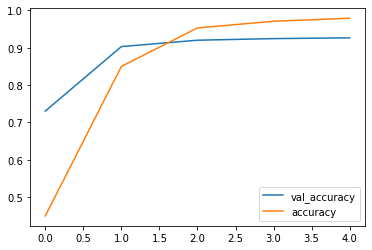

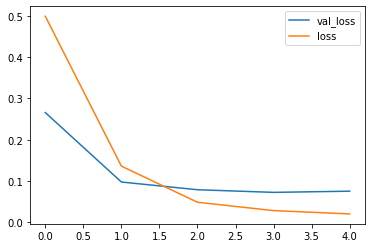

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn

df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

Let's see how well we do on the test set

In [ ]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

13/13 [==============================] - 1s 64ms/step - loss: 0.1013 - accuracy: 0.8904
Test loss: 0.10130263864994049
Test accuracy: 0.89041668176651


Not too bad! Let's see how well it does with sentences that have ambiguous words:

In [ ]:
strange_sentences = ['Their management plan reforms worked'.split(),
                     "Attack was their best option".split()
                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(strange_sentences_int)
print(predictions, predictions.shape)

[[[4.53704931e-02 6.81271404e-02 4.98983935e-02 ... 6.06941022e-02
   8.78989249e-02 5.47552928e-02]
  [1.56417384e-03 6.62179990e-03 1.88026950e-02 ... 3.67467175e-03
   7.12250778e-03 2.39600637e-03]
  [7.57593534e-06 4.94328560e-04 7.63363263e-04 ... 1.47678991e-04
   4.13209014e-02 2.27832861e-05]
  ...
  [8.79498856e-08 4.93686239e-04 1.20245923e-05 ... 8.78197607e-05
   9.97142375e-01 1.52961866e-06]
  [8.79498856e-08 4.93686239e-04 1.20245923e-05 ... 8.78197607e-05
   9.97142375e-01 1.52961866e-06]
  [8.79498856e-08 4.93686239e-04 1.20245923e-05 ... 8.78197607e-05
   9.97142375e-01 1.52961866e-06]]

 [[5.07070236e-02 4.03664894e-02 1.22633725e-01 ... 7.16648772e-02
   8.02533701e-02 5.68495058e-02]
  [5.16141336e-05 9.91104264e-03 1.46906867e-04 ... 1.03627308e-03
   9.52841282e-01 1.64323414e-04]
  [1.97962913e-06 1.01431762e-03 6.21374202e-05 ... 3.67920366e-05
   5.39060042e-04 2.38315788e-05]
  ...
  [1.26210381e-07 2.85512374e-06 1.36938295e-03 ... 2.46333229e-06
   4.45645

Note some things:
1. The output for each word is a probability distribution over tags. Nice if we want it, but here, we are actually more interested in the one **best** tag for each token.
2. the tags are the integer IDs, so we need to translate them back
3. because we padded, the last item just gets repeated
    
We need to fix those before we have useful output:

In [ ]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['Their', 'management', 'plan', 'reforms', 'worked'], ['PRON', 'NOUN', 'NOUN', 'NOUN', 'VERB']), (['Attack', 'was', 'their', 'best', 'option'], ['NOUN', 'VERB', 'PRON', 'ADJ', 'NOUN'])]


Looks ok! Let's see what we get if we process the sentence from both ends.

## Bi-LSTM

In [ ]:
from keras.layers import Bidirectional

# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 87)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 87, 128)           945408    
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 87, 512)           788480    
_________________________________________________________________
dropout (Dropout)            (None, 87, 512)           0         
_________________________________________________________________
output (Dense)               (None, 87, 13)            6669      
_________________________________________________________________
softmax (Activation)         (None, 87, 13)            0         
Total params: 1,740,557
Trainable params: 1,740,557
Non-trainable params: 0
_________________________________________________

We just added a casual 400k parameters to our model!

Epoch 1/5
101/101 [==============================] - 88s 791ms/step - loss: 0.5859 - accuracy: 0.3230 - val_loss: 0.2533 - val_accuracy: 0.7267
Epoch 2/5
101/101 [==============================] - 76s 751ms/step - loss: 0.1549 - accuracy: 0.8261 - val_loss: 0.0735 - val_accuracy: 0.9224
Epoch 3/5
101/101 [==============================] - 76s 754ms/step - loss: 0.0346 - accuracy: 0.9662 - val_loss: 0.0590 - val_accuracy: 0.9374
Epoch 4/5
101/101 [==============================] - 80s 788ms/step - loss: 0.0182 - accuracy: 0.9805 - val_loss: 0.0586 - val_accuracy: 0.9376
Epoch 5/5
101/101 [==============================] - 80s 789ms/step - loss: 0.0125 - accuracy: 0.9871 - val_loss: 0.0652 - val_accuracy: 0.9267


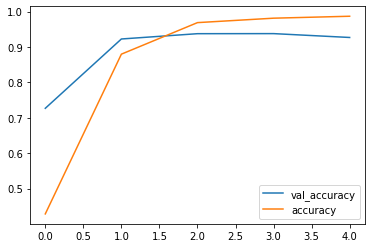

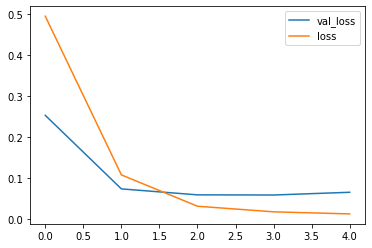

In [ ]:
batch_size = 16
epochs = 5

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [ ]:
loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

13/13 [==============================] - 1s 108ms/step - loss: 0.0823 - accuracy: 0.9075
Test loss: 0.08229780942201614
Test accuracy: 0.9075000286102295


We are getting better on the test data, what about the confusing sentences?

In [ ]:
predictions_bilstm = model_bilstm.predict(strange_sentences_int)
print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions_bilstm))))

[(['Their', 'management', 'plan', 'reforms', 'worked'], ['PRON', 'NOUN', 'NOUN', 'VERB', 'VERB']), (['Attack', 'was', 'their', 'best', 'option'], ['VERB', 'VERB', 'PRON', 'ADJ', 'NOUN'])]


Not so much. We probably need a lot more data to prevent overfitting.

## Exercise

Get the large train, dev, and test data sets for CoNLL, apply the preprocessing steps and run the model on them. What performance do you get?

In [ ]:
# Your code here

## Sequential API Model

When you google for more details, you might come across the **Sequential API** (because we sequentially add layers, not because this is a sequence model). It does the same thing as the functional API, but in a different way. It is less flexible than the functional API we have been using, though.

In [ ]:
from keras.models import Sequential
from keras.layers import InputLayer
np.random.seed(42)

model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(256, return_sequences=True), name='bi-LSTM'))
model_seq.add(Dropout(0.3, name='dropout'))
model_seq.add(Dense(len(tag2int), name='output'))
model_seq.add(Activation('softmax', name='softmax'))
model_seq.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 87, 128)           945408    
_________________________________________________________________
bi-LSTM (Bidirectional)      (None, 87, 512)           788480    
_________________________________________________________________
dropout (Dropout)            (None, 87, 512)           0         
_________________________________________________________________
output (Dense)               (None, 87, 13)            6669      
_________________________________________________________________
softmax (Activation)         (None, 87, 13)            0         
Total params: 1,740,557
Trainable params: 1,740,557
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 32
epochs = 5

model_seq.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_seq.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/5
51/51 [==============================] - 58s 980ms/step - loss: 0.6185 - accuracy: 0.2924 - val_loss: 0.4979 - val_accuracy: 0.4087
Epoch 2/5
51/51 [==============================] - 46s 897ms/step - loss: 0.3735 - accuracy: 0.5907 - val_loss: 0.1371 - val_accuracy: 0.8608
Epoch 3/5
51/51 [==============================] - 47s 920ms/step - loss: 0.0851 - accuracy: 0.9102 - val_loss: 0.0748 - val_accuracy: 0.9235
Epoch 4/5
51/51 [==============================] - 47s 915ms/step - loss: 0.0339 - accuracy: 0.9664 - val_loss: 0.0618 - val_accuracy: 0.9340
Epoch 5/5
51/51 [==============================] - 47s 929ms/step - loss: 0.0190 - accuracy: 0.9815 - val_loss: 0.0604 - val_accuracy: 0.9385


In [ ]:
loss, accuracy = model_seq.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

7/7 [==============================] - 1s 188ms/step - loss: 0.0798 - accuracy: 0.9110
Test loss: 0.07982400804758072
Test accuracy: 0.9110416769981384


The sequential model does have a convenience function, though, `predict_classes()`, which we can use to get the tatg IDs. This changes our inverse transformation a bit, since we no longer need the argmax.

In [ ]:
predictions_seq = model_seq.predict_classes(strange_sentences_int)
for sentence, prediction in zip(strange_sentences, predictions_seq):
    pred_ = [int2tag[prediction[i]] for i in range(len(sentence))]
    print(sentence, pred_)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


['Their', 'management', 'plan', 'reforms', 'worked'] ['PRON', 'NOUN', 'NOUN', 'VERB', 'VERB']
['Attack', 'was', 'their', 'best', 'option'] ['PRON', 'VERB', 'PRON', 'ADJ', 'NOUN']
